# Import packages

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from model import sparsity_loss, dictionary_loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import importlib
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import numpy as np
import gc

# Loading data

In [4]:
train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y, X = train['label'], train.loc[:, train.columns != 'label'] / 255

Split into training and testing sets for possible use later. Also, I wanted to check if the dicitinary works well with new data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
X_train, X_test = X_train.values, X_test.values

In [9]:
X_train = X_train.reshape([X_train.shape[0], 28*28])
X_test = X_test.reshape([X_test.shape[0], 28*28])

# Goal
Mnist digit to dictionary and then back to digit

In [10]:
batch_size = 1680
epsilon = 1e-6
num_filters = 100
patches_per_img = 4
data_size = X_train.shape[0]
num_batches = data_size // batch_size
alpha = 0.01 #learning rate
sparsity_coef = 1 # sparsity coef
beta = .99 #The amount to retain for A and B
img_size = 28
dict_filter_size = img_size**2 //patches_per_img
activity_epochs = 300
epochs=15
num_layers=1

In [11]:
X_train = X_train.reshape([-1, dict_filter_size])
X_test = X_test.reshape([-1, dict_filter_size]) 

# ZCA Preprocessing

In [12]:
def zca(x):
    cov = np.cov(x)
    mean = x.mean()
    w, v = np.linalg.eig(cov)
    w_output = 1/(np.sqrt(w+1e-5))
    output = v @ np.diag(w_output) @ v.T @ (x - mean)
    return output

# Sparse models

In [13]:
def matmul_1d(a, b):
    return tf.einsum('ij,j->i', a, b)
def batch_matmul_1d(a, b):
    return tf.einsum('ij,kj->ki', a, b)

In [14]:
class Activity(keras.layers.Layer):
    def __init__(self, units, batch_size, alpha, sparsity_coef):
        super(Activity, self).__init__()
        self.w_init = tf.random_normal_initializer()
        self.batch_size = batch_size
        self.units = units
        self.w = tf.Variable(
            initial_value=self.w_init(shape=(batch_size, units), dtype="float32"),
            trainable=False,
        )
        self.rate = alpha
        self.sparsity_coef = sparsity_coef
    def shrink(self):
        a = self.w
        b = self.rate * self.sparsity_coef
        prior_shrink = tf.abs(a) - b
        shrink_positive = tf.clip_by_value(prior_shrink, 0, np.inf)
        sign_a = tf.math.sign(a)
        a.assign(sign_a * shrink_positive)
    def update(self, dictionary, x):
        tf.debugging.assert_all_finite(self.w, 'Check activity weights finite')
        batch_size = x.shape[0]
        self.w[:batch_size].assign(self.w[:batch_size]-self.rate* \
            tf.einsum('ij, ki->kj', dictionary, (tf.einsum('ij,kj->ki', dictionary, self.w[:batch_size])-x)))
        self.shrink()
    def reset(self):
        self.w.assign(self.w_init(shape=(self.batch_size, self.units), dtype="float32"))
    def call(self, dictionary, batch_size):
        return batch_matmul_1d(dictionary, self.w[:batch_size])

In [15]:
class Dictionary(keras.layers.Layer):
    def __init__(self, units, dict_filter_size, beta):
        super(Dictionary, self).__init__()
        w_init = tf.random_normal_initializer()
        self.units = units
        self.beta = beta
        self.A = tf.Variable(
            initial_value=w_init(shape=(units, units), dtype="float32"),
            trainable=False,
        )
        self.B = tf.Variable(
            initial_value=w_init(shape=(dict_filter_size, units), dtype="float32"),
            trainable=False,
        )
        self.w =  tf.Variable(
            initial_value=w_init(shape=(dict_filter_size, units), dtype="float32"),
            trainable=False,
        )
        for i in range(self.units):
            self.w[:, i].assign(self.w[:, i] / tf.norm(self.w[:, i])+epsilon)
    def call(self, inputs, activity):
        return tf.matmul(self.dictionary, activity)
    def update_AB(self, activity, x):
        tf.debugging.assert_all_finite(self.w, 'Check A finite')
        tf.debugging.assert_all_finite(self.w, 'Check B finite')
        batch_size = x.shape[0]
        self.A.assign(self.beta*self.A + (1-self.beta)*tf.reduce_mean(\
            tf.einsum('ij,ik->ijk', activity[:batch_size], activity[:batch_size]), axis=0))
        self.B.assign(self.beta*self.B + (1-self.beta)*tf.reduce_mean(tf.einsum('ij,ik->ijk', x, activity[:batch_size]), axis=0))
    def update(self):
        tf.debugging.assert_all_finite(self.w, 'Check dictionary weights finite')
        epsilon = 1e-5
        for i in range(self.units):
            self.w[:, i].assign(1/(self.A[i, i]+epsilon) * (self.B[:, i] - tf.einsum('ij,j->i',self.w,self.A[:, i])+self.w[:, i]*self.A[i, i]))
            self.w[:, i].assign(self.w[:, i] / tf.norm(self.w[:, i])+epsilon)


In [16]:
class SparseModel(keras.Model):
    def __init__(self, activity, dictionary, activity_epochs, dict_filter_size, \
                data_size, batch_size, num_layers):
        super(SparseModel, self).__init__()
        self.activity = activity
        self.dictionary = dictionary
        self.dict_filter_size = dict_filter_size
        self.data_size = data_size
        self.batch_size = batch_size
        self.activity_epochs = activity_epochs
        self.batch_num = data_size // batch_size + (1 if (self.data_size % self.batch_size) else 0)
        self.num_layers = num_layers
    def compile(self, sparsity_loss, dictionary_loss):
        super(SparseModel, self).compile()
        self.sparsity_loss = sparsity_loss
        self.dictionary_loss = dictionary_loss
    @tf.function
    def train_step_end(self):
        if self._train_counter % self.batch_num == 0:
            self.dictionary.update()
    def train_step(self, patches):
        patches = tf.cast(patches, dtype=tf.float32)
        batch_size = patches.shape[0]
        patches = tf.reshape(patches, [-1, self.dict_filter_size])
        self.activity.reset()
        
        dictionary = self.dictionary.w
        activity = self.activity.w
        for _ in range(self.activity_epochs):
            self.activity.update(dictionary, patches)
        dictionary_loss = self.dictionary_loss(dictionary, activity, patches)
        tf.debugging.assert_all_finite(dictionary_loss, 'Check dictionary loss')
        sparsity_loss = self.sparsity_loss(activity, self.activity.rate*self.activity.sparsity_coef)
        tf.debugging.assert_all_finite(sparsity_loss, 'Check sparsity loss')
        self.dictionary.update_AB(activity, patches)
        self.train_step_end()
        return {'dictionary loss': dictionary_loss, 'sparsity loss': sparsity_loss}
    def call(self, patches):
        patches = tf.cast(patches, dtype=tf.float32)
        patches = tf.reshape(patches, [-1, self.dict_filter_size])
        self.activity.reset()

        dictionary = self.dictionary.w
        for _ in range(self.activity_epochs):
            self.activity.update(dictionary, patches)
        return self.activity.call(self.dictionary.w, batch_size=patches.shape[0])

In [17]:
sparse_activity = Activity(batch_size=batch_size, units=num_filters, alpha=alpha, sparsity_coef=sparsity_coef)
sparse_dictionary = Dictionary(units=num_filters, dict_filter_size=dict_filter_size, beta=beta)
sparse_model = SparseModel(sparse_activity, sparse_dictionary, batch_size=batch_size, activity_epochs=activity_epochs, dict_filter_size=dict_filter_size, data_size=data_size, num_layers=num_layers)
sparse_model.compile(sparsity_loss, dictionary_loss)
datagen = ImageDataGenerator()
datagen.fit(X_train.reshape([-1, dict_filter_size, 1, 1]))
train_generator = datagen.flow(X_train.reshape([-1, dict_filter_size, 1, 1]), batch_size=batch_size)

In [18]:
X_train.shape

(112560, 196)

In [19]:
sparse_model.fit(train_generator, epochs=epochs, batch_size=batch_size)

Epoch 1/15
67/67 [==============================] - 37s 310ms/step - dictionary loss: 0.0550 - sparsity loss: 1.9648e-05
Epoch 2/15
67/67 [==============================] - 20s 290ms/step - dictionary loss: 0.0424 - sparsity loss: 1.2541e-04
Epoch 3/15
67/67 [==============================] - 20s 297ms/step - dictionary loss: 0.0323 - sparsity loss: 1.8801e-04
Epoch 4/15
67/67 [==============================] - 20s 304ms/step - dictionary loss: 0.0291 - sparsity loss: 2.1452e-04
Epoch 5/15
67/67 [==============================] - 20s 295ms/step - dictionary loss: 0.0261 - sparsity loss: 2.3333e-04
Epoch 6/15
67/67 [==============================] - 19s 290ms/step - dictionary loss: 0.0251 - sparsity loss: 2.4069e-04
Epoch 7/15
67/67 [==============================] - 19s 289ms/step - dictionary loss: 0.0238 - sparsity loss: 2.5208e-04
Epoch 8/15
67/67 [==============================] - 19s 284ms/step - dictionary loss: 0.0221 - sparsity loss: 2.6563e-04
Epoch 9/15
67/67 [==============

# Filters

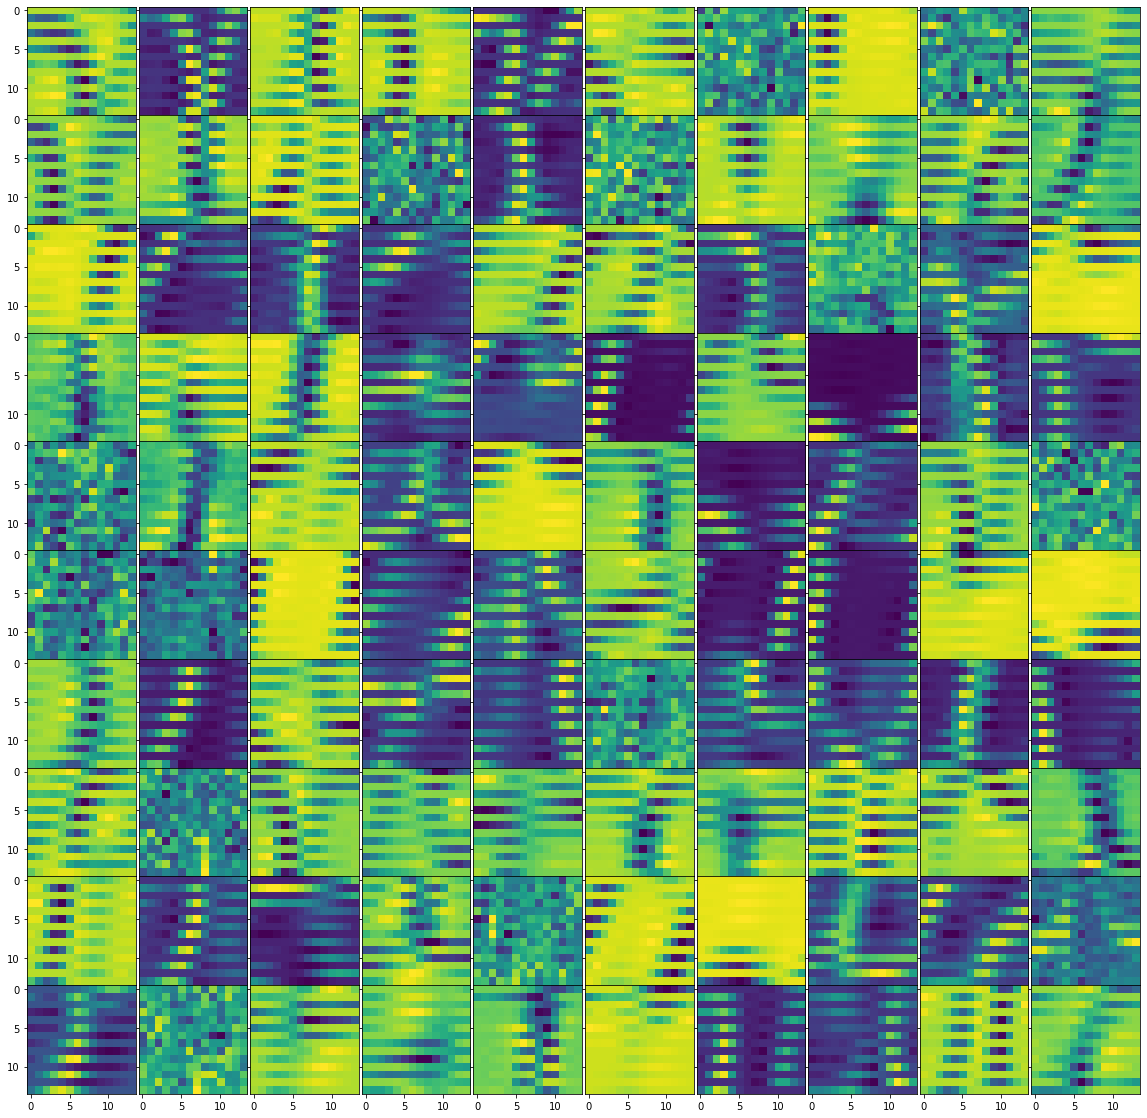

In [20]:
fig = plt.figure(figsize=(20, 20))
num_cols = 10
gs = fig.add_gridspec(num_filters //num_cols, num_cols, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_filters):
    axs[i // num_cols][i % num_cols].imshow(tf.reshape(sparse_model.dictionary.w[:, i], shape=[14,14]))
plt.show()

# Reconstructions

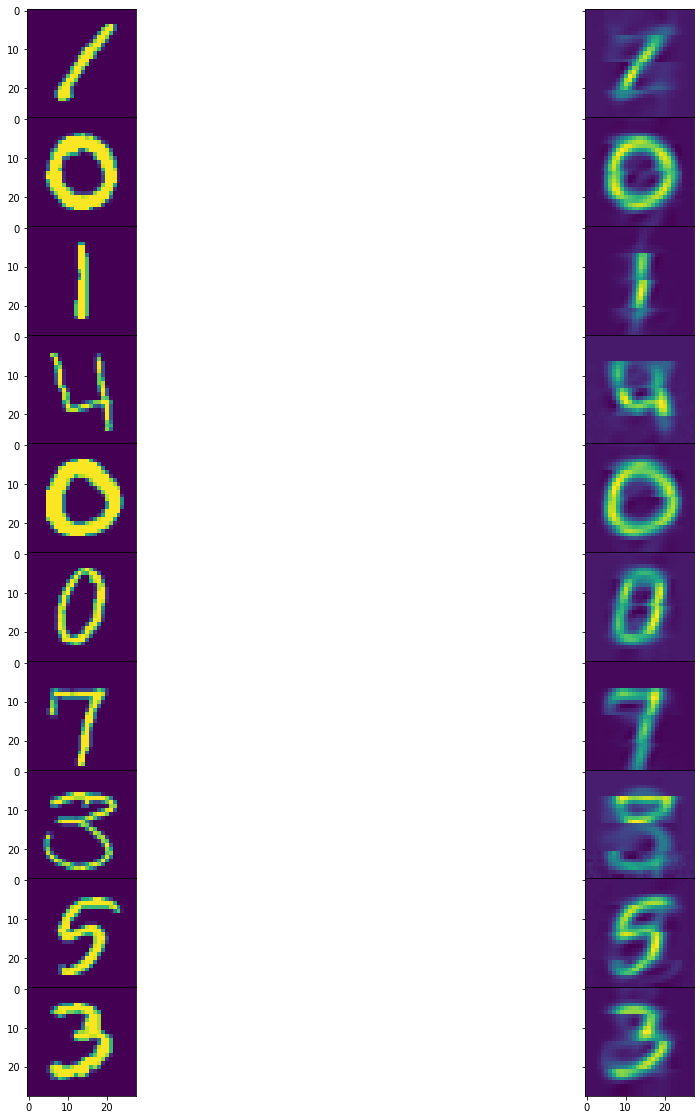

In [21]:
num_reconstructions = 10
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(num_reconstructions, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_reconstructions):
    axs[i][0].imshow(X.values[i].reshape([28, 28]))
    reconstructions = sparse_model.call(X.values[i].reshape([-1, dict_filter_size, 1, 1]))
    axs[i][1].imshow(tf.reshape(reconstructions, [28, 28]))
plt.show()

# Observations
- If not enough filters, the model chooses to decrease sparsity loss while barely decreasing dictionary loss

# LCA
https://arxiv.org/pdf/1711.07998.pdf

# Conv
https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Gu_Convolutional_Sparse_Coding_ICCV_2015_paper.pdf

since between the patches there seems to be a clearly visible boundary, can we use convolution instead?

conv derivatives:

Loss is 

$$L=\dfrac{1}{2}(D*a-x)^2+\lambda \mid a \mid$$

The transpose conv derivates are:
$$\dfrac{\delta L}{\delta a} = (D*a-x)\dfrac{\delta D*a}{\delta a}$$
$$\dfrac{\delta L}{\delta D} = (D*a-x)\dfrac{\delta D*a}{\delta D}$$

Use https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c

Gradient wrt the conv layer: $(D*a-x)$. Now we need to find the derivative

If $D*a$ was a conv operation, then D=filter a=input and

$$
\dfrac{\delta L}{\delta D}=a*(D*a-x)
$$
$$
\dfrac{\delta L}{\delta a}=D_{180}*(D*a-x)_{padded}
$$

now given

$$
\begin{matrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}\\
w_{31} & w_{32} & w_{33}
\end{matrix}
*
\begin{matrix}
a_{11} & a_{12}\\
a_{21} & a_{22}
\end{matrix}
=X_{approx}
$$

if stride=1 padding=0
$$\dfrac{\delta X_{approx}}{\delta a_{11}}=
\begin{matrix}
W & 0\\
0 & 0
\end{matrix}
$$
if stride=2 padding=0
$$\dfrac{\delta X_{approx}}{\delta a_{11}}=
\begin{matrix}
W & 0 & 0\\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{matrix}
$$

so $\dfrac{\delta X_{approx}}{\delta a_{11}}$ has the shape of the output

on the otherhand

Now we know that

$$\dfrac{\delta L}{\delta a_{ij}} = \dfrac{\delta L}{\delta X_{k}}\dfrac{\delta X_{k}}{\delta a_{ij}}$$

Thus
$$\dfrac{\delta L}{\delta a}=D*(D*^Ta-x)$$

What about $\dfrac{\delta L}{\delta D}$
now given

$$
\begin{matrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}\\
w_{31} & w_{32} & w_{33}
\end{matrix}
*
\begin{matrix}
a_{11} & a_{12}\\
a_{21} & a_{22}
\end{matrix}
=X_{approx}
$$
$$\dfrac{\delta X_{approx}}{\delta w_{11}}=
\begin{matrix}
a & 0\\
0 & 0
\end{matrix}
$$
If stride=2
$$\dfrac{\delta X_{approx}}{\delta w_{11}}=
\begin{matrix}
a_{11} & 0 & a_{12} & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
a_{21} & 0 & a_{22} & 0 & 0\\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{matrix}
$$

# Overlapping patches

Check out https://www.sciencedirect.com/topics/engineering/sparse-coding

For this the overlapping portion must be the same as the patch size? zero padding can fix this

# Sparse layers

## ZCA whitening should increase performance